# kmeansとxmeansのスクラッチ実装で学ぶPythonのクラス

## kmeans

In [111]:
import numpy as np

class Kmeans:
        
    def __init__(self):
        
        self.X = None
        self.N = None
        self.M = None
        self.K = None
        self.max_iter = 1000
        self.labels  = None 
        self.centers = None
        
    
    def fit (self, X, K = 2):

        self.X = X
        self.N, self.M = self.X.shape
        self.K = max(K, 2)
        self.__initialize_centers_kmeanspp()
        self.__update_labels(); 
        
        old_labels = self.labels
        iter = 0
        while True:
            
            self.__update_centers()
            self.__update_labels()
            
            if np.all(old_labels == self.labels):
                print("iteration {n}".format(n = iter))
                break
            old_labels = self.labels
                                   
            iter += 1
            if iter  > self.max_iter :
                print("iteration reached {max}".format(max = self.max_iter))
                break
        
        return None
    

    def predict(self, X):
        
        dist2  = np.sum((X[np.newaxis, :, :] - self.centers[:, np.newaxis, :])**2, axis = 2)
        labels = np.argmin(dist2, axis = 0)
        
        return labels
        
        
    def __initialize_centers_random(self):
        
        random_center_indexs = np.random.choice(a = self.N, size = self.K, replace = False)
        self.centers = self.X[random_center_indexs,:]
        
        return None
    
    def __initialize_centers_kmeanspp(self):
        
        center_index = np.random.choice(self.N, size = 1)
        min_dist2 = np.repeat(np.Inf, self.N)
    
        for k in np.arange(0, self.K - 1):
            
            dist2_to_center_k = np.sum((self.X - self.X[center_index[k], :]) ** 2 , axis = 1)
            min_dist2 = np.where(dist2_to_center_k < min_dist2, dist2_to_center_k, min_dist2)
            probs = min_dist2 / np.sum(min_dist2)
            new_center_index = np.random.choice(self.N, size = 1, p = probs)
            center_index = np.r_[center_index, new_center_index]
            
        self.centers = self.X[center_index, :]
        
        return None
    
    
    def __update_centers(self):
            
        new_centers = []
        for k_label in np.arange(self.K):
            k_center = np.mean(self.X[self.labels == k_label, :], axis = 0)
            new_centers.append(k_center)
        self.centers = np.array(new_centers)
                    
        return None
                     
    
    def __update_labels(self):
        
        dist2 = np.sum((self.X[np.newaxis, :, :] - self.centers[:, np.newaxis, :]) ** 2, axis = 2)
        self.labels = np.argmin(dist2, axis = 0)
        
        return None
    

        

In [112]:
X = np.random.normal(size = 100  * 2).reshape(100, 2)
km = Kmeans()
km.fit(X, 3)

iteration 3


In [113]:
fit2 = km.predict(X)
np.all(fit2 == km.labels)

True

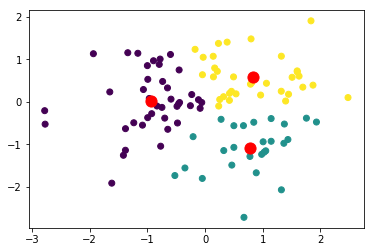

In [114]:
from matplotlib import pyplot as plt
%matplotlib inline

f, ax = plt.subplots()
ax.scatter(km.X[:,0], km.X[:,1], c = km.labels)
ax.scatter(km.centers[:, 0], km.centers[:, 1], c = "red", s = 124)

## xmeans

In [115]:
from scipy.stats import multivariate_normal as mulnorm
from scipy import stats
import numpy as np


class Xmeans:
    
    def __init__(self):
        self.X = None
        self.N = None
        self.M = None
        self.labels   = None 
        self.clusters = None    # set of data index by cluster
        self.centers  = None
        self.km = Kmeans()
        
    def fit(self, X):
        self.clusters = []
        self.X = X
        self.N, self.M = X.shape
        self.__recursive_kmeans()
        self.centers = np.array([np.mean(X[cls, :], axis = 0) for cls in self.clusters])
        labs = np.zeros(self.N)
        for i, cls in enumerate(self.clusters):
            labs[cls] = i
        self.labels = labs

        return None
        
    
    def __recursive_kmeans(self, cluster = None):
        if cluster is None:
            cluster = np.arange(self.N)
        self.km.fit(self.X[cluster, :], 2)
        labs = self.km.labels
        if not self.__is_computable(labs):
            self.clusters.append(cluster)
            return None
        
        splt_cls = [cluster[np.where(labs == v)] for v in np.unique(labs)]
        xbic  = self.__xbic(self.X[cluster, :])
        xbicp = self.__xbicp(self.X[splt_cls[0], :], self.X[splt_cls[1], :]) 
        
        if xbicp < xbic:
            for cls in splt_cls:
                self.__recursive_kmeans(cls)
        else:
            self.clusters.append(cluster)

        return None
        
        
    def __is_computable(self, labs):
        is_zero = labs == 0
        return np.sum(is_zero) >= 3 and np.sum(np.logical_not(is_zero)) >= 3
            
    
    def __xbic(self, X):
        N, M = X.shape
        cv = np.cov(X.T)
        df = M * (M + 3) * .5
        center = np.mean(X, axis = 0)
        bic = - 2 * np.sum(mulnorm.logpdf(X, center, cv)) + df * np.log(N)
        
        return bic
    
    
    def __xbicp(self, X1, X2):
        N1, M  = X1.shape
        N2, _  = X2.shape
        df = M * (M  + 3)
        
        centers = np.array([np.mean(X, axis = 0) for X in [X1, X2]])
        covs = [np.cov(X.T) for X in [X1, X2]]
        sum_dets = np.sum([np.linalg.det(cov) for cov in covs])
        
        beta = np.sqrt(np.sum((centers[0] - centers[1]) **2) / sum_dets)
        log_alpha = - np.log(2) - stats.norm.logcdf(beta)
        loglikelihood = np.sum([np.sum(mulnorm.logpdf(X, cet, cov)) for X, cet, cov in zip([X1, X2], centers, covs)])
        
        bicp = - 2 * ((N1 + N2) * log_alpha + loglikelihood) + df * np.log(N1 + N2)
        
        return bicp
        
 
    


In [116]:
X1 = np.random.normal(size = 100  * 2).reshape(100, 2) * .8
X2 = X1 + np.array([5,  0])
X3 = X1 + np.array([0,  5])
X4 = X1 + np.array([-5,  0])
X5 = X1 + np.array([0, -5])
X  = np.r_[X1, X2, X3, X4, X5]
xkm = Xmeans()
xkm.fit(X)

iteration 1
iteration 1
iteration 1
iteration 1
iteration 8
iteration 9
iteration 3
iteration 4
iteration 8


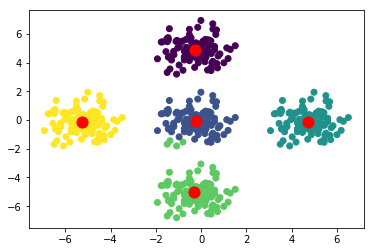

In [117]:
from matplotlib import pyplot as plt
%matplotlib inline

f, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c = xkm.labels)
ax.scatter(xkm.centers[:, 0], xkm.centers[:, 1], c = "red", s = 124)

iteration 5
iteration 0
iteration 2
iteration 5
iteration 0
iteration 12
iteration 2


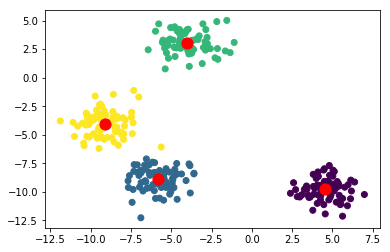

In [118]:
from sklearn.datasets import make_blobs
# 特徴量行列、 ターゲットベクトルを生成
features, target = \
    make_blobs(n_samples = 300,
               n_features = 2,
               centers = 4,
               cluster_std = 1,
               shuffle = True,
               random_state = 21)

xkm.fit(features)
f, ax = plt.subplots()
ax.scatter(features[:,0], features[:,1], c = xkm.labels)
ax.scatter(xkm.centers[:, 0], xkm.centers[:, 1], c = "red", s = 124)

## kmeans-mahalanobis

In [102]:
from scipy.stats import multivariate_normal as mulnorm
from scipy import stats
import numpy as np

class KmeansMahalanobis:
    
    def __init__(self):
        self.K = None
        self.X = None
        self.N = None
        self.M = None
        self.DF = None
        self.max_iter = 100
        self.labels   = None
        self.centers  = None
        self.clusters = None
        self.covs = None
        self.loglikelihood = None
        self.IC = {"AIC":0, "BIC":0}
        self.km = Kmeans()
    
    def fit(self, X, K = 2):
        
        self.X = X
        self.N, self.M = X.shape
        self.K = K
        self.DF = (self.M + 3) * self.M / 2 * self.K
        self.km.fit(self.X, self.K)
        self.labels = self.km.labels
        self.__update_params()
       
        iter = 0
        old_labs = self.km.labels
        while True:
            
            loglikelihoods = np.array([mulnorm.logpdf(self.X, self.centers[k], self.covs[k]) for k in range(self.K)])
            self.labels    = np.argmax(loglikelihoods, axis = 0)
            self.__update_params()
            
            if np.all(old_labs == self.labels):
                break
            old_labs = self.labels
            
            iter += 1
            if iter > self.max_iter:
                print("reached max itertion\n")
                break
                
        print("iteration loglikelihood: {a} ".format(a = iter))
        log_cluster_weight = np.log(np.array([np.sum(self.labels == k) for k in range(self.K)])) - np.log(self.N)
        self.loglikelihood = \
            np.sum(np.log(np.sum(\
                                 np.exp(loglikelihoods + log_cluster_weight.reshape(self.K, 1)), \
                                 axis = 0)))
            
        self.__update_IC()
 
            
    def __update_params(self):
        
        self.centers = [np.mean(self.X[self.labels == k,:], axis = 0) for k in range(self.K)]
        self.covs = [np.cov(self.X[self.labels == k,:].T) for k in range(self.K)]
        
        return None
    
    def __update_IC(self):
        
        self.IC["AIC"] = - 2 * self.loglikelihood + 2 * self.DF
        self.IC["BIC"] = - 2 * self.loglikelihood + self.DF * np.log(self.N)
        
        return None
    

In [103]:
kmm = KmeansMahalanobis()

iteration 0
iteration loglikelihood: 0 


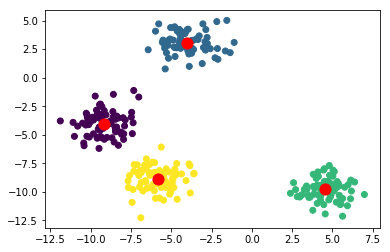

In [104]:
kmm.fit(features, 4)
f, ax = plt.subplots()
ax.scatter(features[:,0], features[:,1], c = kmm.labels)
for k in range(kmm.K):
    ax.scatter(kmm.centers[k][0], kmm.centers[k][1], c = "red", s = 124)

In [105]:
kmm.IC

{'AIC': 2569.7562821537244, 'BIC': 2643.8319316468483}

In [106]:
from sklearn import datasets
iris = datasets.load_iris()

In [107]:
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

iteration 1
iteration loglikelihood: 8 


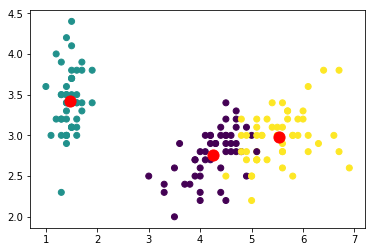

In [108]:
kmm.fit(iris.data, 3)
f, ax = plt.subplots()
ax.scatter(iris.data[:,2], iris.data[:,1], c = kmm.labels)
for k in range(kmm.K):
    ax.scatter(kmm.centers[k][2], kmm.centers[k][1], c = "red", s = 124)